# Train a Deep NN to predict Asset Price returns

In practice, we need to explore variations of the design options outlined above because we can rarely be sure from the outset which network architecture best suits the data.

In this section, we will explore various options to build a simple feedforward Neural Network to predict asset price returns for a one-day horizon.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from ast import literal_eval as make_tuple
from time import time
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
np.random.seed(42)
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [6]:
DATA_STORE = '../data/assets.h5'

In [7]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()
    
checkpoint_path = results_path / 'logs'

## Create a stock return series to predict asset price moves

To develop our trading strategy, we use the daily stock returns for some 995 US stocks for the eight year period from 2010 to 2017, and the features developed in Chapter 12 that include volatility and momentum factors as well as lagged returns with cross-sectional and sectoral rankings.

In [8]:
data = pd.read_hdf('../12_gradient_boosting_machines/data.h5', 'model_data').dropna().sort_index()

In [9]:
data

dollar_vol  dollar_vol_rank        rsi   bb_high    bb_low  \
symbol date                                                                     
A      2010-04-06   59.013972            265.0  66.771115  0.011995  0.046835   
       2010-04-07   54.711625            273.0  61.602096  0.019961  0.037171   
       2010-04-08   69.665478            283.0  56.379539  0.028458  0.028148   
       2010-04-09   65.292929            287.0  59.348720  0.022221  0.033378   
       2010-04-12   69.026435            286.0  58.988376  0.022739  0.030553   
...                       ...              ...        ...       ...       ...   
ZION   2017-11-22   55.780835            383.0  51.369835  0.033854  0.042161   
       2017-11-24   31.916610            397.0  51.369835  0.034191  0.041774   
       2017-11-27   77.300255            409.0  51.925642  0.031743  0.043113   
       2017-11-28  153.220030            395.0  62.838041  0.001521  0.076308   
       2017-11-29  196.845040            380.0  69.158377 -0.015133  0.106084   

                       NATR       ATR       PPO      MACD  sector  ...  \
symbol date                                                        ...   
A      2010-04-06  1.456333 -2.195082  1.955973  0.597133       8  ...   
       2010-04-07  1.452530 -2.214063  1.915119  0.534065       8  ...   
       2010-04-08  1.516316 -2.151267  1.792541  0.445856       8  ...   
       2010-04-09  1.473258 -2.191503  1.614987  0.391718       8  ...   
       2010-04-12  1.428331 -2.248284  1.466435  0.339487       8  ...   
...                     ...       ...       ...       ...     ...  ...   
ZION   2017-11-22  2.161103  1.349572 -0.728112 -0.043146       2  ...   
       2017-11-24  2.088415  1.188821 -0.775884 -0.044000       2  ...   
       2017-11-27  2.031720  1.070224 -0.518905 -0.036497       2  ...   
       2017-11-28  2.076556  1.334994  0.053990  0.206908       2  ...   
       2017-11-29  2.142136  1.628565  0.825971  0.593644       2  ...   

                   r10q_sector  r21q_sector  r42q_sector  r63q_sector  \
symbol date                                                             
A      2010-04-06          2.0          1.0          3.0          2.0   
       2010-04-07          2.0          1.0          2.0          2.0   
       2010-04-08          1.0          1.0          2.0          2.0   
       2010-04-09          0.0          1.0          2.0          2.0   
       2010-04-12          0.0          1.0          2.0          2.0   
...                        ...          ...          ...          ...   
ZION   2017-11-22          4.0          2.0          1.0          1.0   
       2017-11-24          4.0          3.0          1.0          1.0   
       2017-11-27          4.0          2.0          1.0          1.0   
       2017-11-28          3.0          3.0          2.0          1.0   
       2017-11-29          3.0          3.0          2.0          2.0   

                    r01_fwd   r05_fwd   r21_fwd  year  month  weekday  
symbol date                                                            
A      2010-04-06 -0.007812 -0.019097  0.005787  2010      4        1  
       2010-04-07 -0.008749  0.003500 -0.029455  2010      4        2  
       2010-04-08  0.007061  0.048249 -0.062371  2010      4        3  
       2010-04-09 -0.000584  0.030383 -0.001169  2010      4        4  
       2010-04-12 -0.009062  0.027770 -0.004092  2010      4        0  
...                     ...       ...       ...   ...    ...      ...  
ZION   2017-11-22  0.000000  0.069040  0.107443  2017     11        2  
       2017-11-24  0.001510  0.080475  0.097303  2017     11        4  
       2017-11-27  0.035976  0.114606  0.092417  2017     11        0  
       2017-11-28  0.029112  0.058016  0.067582  2017     11        1  
       2017-11-29  0.001212  0.008689  0.027076  2017     11        2  

[1911344 rows x 34 columns]

In [10]:
data.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1911344 entries, ('A', Timestamp('2010-04-06 00:00:00')) to ('ZION', Timestamp('2017-11-29 00:00:00'))
Data columns (total 34 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol       1911344 non-null  float64
 1   dollar_vol_rank  1911344 non-null  float64
 2   rsi              1911344 non-null  float64
 3   bb_high          1911344 non-null  float64
 4   bb_low           1911344 non-null  float64
 5   NATR             1911344 non-null  float64
 6   ATR              1911344 non-null  float64
 7   PPO              1911344 non-null  float64
 8   MACD             1911344 non-null  float64
 9   sector           1911344 non-null  int32  
 10  r01              1911344 non-null  float64
 11  r05              1911344 non-null  float64
 12  r10              1911344 non-null  float64
 13  r21              1911344 non-null  float64
 14  r42              1911344 non-null  float6

In [11]:
outcomes = data.filter(like='fwd').columns.tolist()

In [12]:
lookahead = 1
outcome= f'r{lookahead:02}_fwd'

In [13]:
X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
y_cv = data.loc[idx[:, :'2017'], outcome]

In [14]:
X_cv.index.get_level_values('symbol').unique()

Index(['A', 'AAL', 'AAN', 'AAP', 'AAPL', 'ABC', 'ABMD', 'ABT', 'ACC', 'ACGL',
       ...
       'XLNX', 'XOM', 'XPO', 'XRAY', 'XRX', 'Y', 'YUM', 'ZBH', 'ZBRA', 'ZION'],
      dtype='object', name='symbol', length=995)

In [15]:
len(X_cv.index.get_level_values('symbol').unique())

995

In [21]:
outcome

'r01_fwd'

In [22]:
#X_cv.info(null_counts=True)

## Automate model generation

The following `make_model` function illustrates how to flexibly define various architectural elements for the search process. The dense_layers argument defines both the depth and width of the network as a list of integers. We also use dropout for regularization, expressed as a float in the range [0, 1] to define the probability that a given unit will be excluded from a training iteration.

In [23]:
def make_model(dense_layers, activation, dropout):
    '''Creates a multi-layer perceptron model
    
    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=X_cv.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(layer_size))
            model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='Adam')

    return model

## Cross-validate multiple configurations with TensorFlow

### Train-Test Split

We split the data into a training set for cross-validation, and keep the last 12 months with data as holdout test:

In [24]:
n_splits = 12
train_period_length=21 * 12 * 4
test_period_length=21 * 3

In [25]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

### Define CV Parameters

Now we just need to define our Keras classifier using the make_model function, set cross-validation (see chapter 6 on The Machine Learning Process and following for the OneStepTimeSeriesSplit), and the parameters that we would like to explore. 

We pick several one- and two-layer configurations, relu and tanh activation functions, and different dropout rates. We could also try out different optimizers (but did not run this experiment to limit what is already a computationally intensive effort):

In [30]:
dense_layer_opts = [(32, 32), (16, 8)]#[(16, 8), (32, 16), (32, 32), (64, 32)]
activation_opts = ['tanh']
dropout_opts = [.1]#[0, .1, .2]

In [31]:
param_grid = list(product(dense_layer_opts, activation_opts, dropout_opts))
np.random.shuffle(param_grid)

In [32]:
param_grid

[((16, 8), 'tanh', 0.1), ((32, 32), 'tanh', 0.1)]

In [33]:
len(param_grid)

2

To trigger the parameter search, we instantiate a GridSearchCV object, define the fit_params that will be passed to the Keras model’s fit method, and provide the training data to the GridSearchCV fit method:

In [34]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    return x_train, y_train, x_val, y_val

In [35]:
ic = []
scaler = StandardScaler()
for params in param_grid:
    dense_layers, activation, dropout = params
    for batch_size in [256]: #[64, 256]:
        print(dense_layers, activation, dropout, batch_size)
        checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(dropout) / str(batch_size)
        if not checkpoint_dir.exists():
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
        start = time()
        for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
            # get train & validation data
            x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
            
            # scale features
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.transform(x_val)
            
            # set up dataframes to log results
            preds = y_val.to_frame('actual')
            r = pd.DataFrame(index=y_val.groupby(level='date').size().index)
            
            # create model based on validation parameters
            model = make_model(dense_layers, activation, dropout)
            
            # cross-validate for 20 epochs
            for epoch in range(20):            
                model.fit(x_train,
                          y_train,
                          batch_size=batch_size,
                          epochs=1,
                          verbose=0,
                          shuffle=True,
                          validation_data=(x_val, y_val))
                model.save_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
                preds[epoch] = model.predict(x_val).squeeze()
                r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
                print(format_time(time()-start), f'{fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
            ic.append(r.assign(dense_layers=str(dense_layers), 
                               activation=activation, 
                               dropout=dropout,
                               batch_size=batch_size,
                               fold=fold))       

        t = time()-start
        pd.concat(ic).to_hdf(results_path / 'scores.h5', 'ic_by_day')

(16, 8) tanh 0.1 256
1921/1921 [==============================] - 3s 2ms/step
00:00:26 01 | 01 |  0.0126 |  0.0043
1921/1921 [==============================] - 3s 2ms/step
00:00:39 01 | 02 | -0.0097 | -0.0150
1921/1921 [==============================] - 3s 2ms/step
00:00:53 01 | 03 |  0.0188 |  0.0002
1921/1921 [==============================] - 3s 2ms/step
00:01:08 01 | 04 |  0.0103 |  0.0149
1921/1921 [==============================] - 3s 2ms/step
00:01:22 01 | 05 |  0.0033 |  0.0013
1921/1921 [==============================] - 3s 2ms/step
00:01:36 01 | 06 |  0.0105 |  0.0110
1921/1921 [==============================] - 3s 2ms/step
00:01:49 01 | 07 |  0.0066 | -0.0177
1921/1921 [==============================] - 3s 2ms/step
00:02:02 01 | 08 |  0.0057 | -0.0127
1921/1921 [==============================] - 3s 2ms/step
00:02:16 01 | 09 |  0.0137 |  0.0186
1921/1921 [==============================] - 3s 2ms/step
00:02:32 01 | 10 |  0.0107 |  0.0287
1921/1921 [============================

1959/1959 [==============================] - 3s 2ms/step
00:22:01 05 | 08 |  0.0185 |  0.0217
1959/1959 [==============================] - 3s 2ms/step
00:22:14 05 | 09 |  0.0234 |  0.0334
1959/1959 [==============================] - 3s 2ms/step
00:22:29 05 | 10 |  0.0146 |  0.0490
1959/1959 [==============================] - 3s 2ms/step
00:22:50 05 | 11 |  0.0157 |  0.0343
1959/1959 [==============================] - 3s 2ms/step
00:23:03 05 | 12 |  0.0101 |  0.0175
1959/1959 [==============================] - 3s 2ms/step
00:23:16 05 | 13 | -0.0017 |  0.0022
1959/1959 [==============================] - 3s 2ms/step
00:23:30 05 | 14 |  0.0087 |  0.0235
1959/1959 [==============================] - 3s 2ms/step
00:23:44 05 | 15 |  0.0077 |  0.0048
1959/1959 [==============================] - 3s 2ms/step
00:23:57 05 | 16 |  0.0070 |  0.0028
1959/1959 [==============================] - 3s 2ms/step
00:24:10 05 | 17 | -0.0114 | -0.0157
1959/1959 [==============================] - 3s 2ms/step
00:

1959/1959 [==============================] - 3s 2ms/step
00:42:60 09 | 15 |  0.0159 |  0.0132
1959/1959 [==============================] - 3s 2ms/step
00:43:14 09 | 16 |  0.0261 |  0.0031
1959/1959 [==============================] - 3s 2ms/step
00:43:28 09 | 17 |  0.0266 |  0.0272
1959/1959 [==============================] - 3s 2ms/step
00:43:41 09 | 18 |  0.0281 |  0.0302
1959/1959 [==============================] - 3s 2ms/step
00:43:55 09 | 19 |  0.0237 |  0.0089
1959/1959 [==============================] - 3s 2ms/step
00:44:11 09 | 20 |  0.0220 |  0.0096
1957/1957 [==============================] - 3s 2ms/step
00:44:35 10 | 01 | -0.0117 | -0.0053
1957/1957 [==============================] - 3s 2ms/step
00:44:49 10 | 02 | -0.0069 | -0.0189
1957/1957 [==============================] - 3s 2ms/step
00:45:02 10 | 03 | -0.0144 | -0.0232
1957/1957 [==============================] - 3s 2ms/step
00:45:16 10 | 04 |  0.0114 |  0.0083
1957/1957 [==============================] - 4s 2ms/step
00:

1924/1924 [==============================] - 3s 2ms/step
00:06:44 02 | 02 |  0.0048 |  0.0080
1924/1924 [==============================] - 3s 2ms/step
00:07:02 02 | 03 |  0.0021 |  0.0068
1924/1924 [==============================] - 3s 2ms/step
00:07:17 02 | 04 |  0.0169 |  0.0214
1924/1924 [==============================] - 3s 1ms/step
00:07:34 02 | 05 | -0.0136 | -0.0203
1924/1924 [==============================] - 3s 1ms/step
00:07:51 02 | 06 |  0.0213 |  0.0201
1924/1924 [==============================] - 3s 1ms/step
00:08:09 02 | 07 |  0.0291 |  0.0346
1924/1924 [==============================] - 3s 1ms/step
00:08:24 02 | 08 |  0.0124 |  0.0019
1924/1924 [==============================] - 3s 1ms/step
00:08:42 02 | 09 |  0.0026 |  0.0007
1924/1924 [==============================] - 6s 3ms/step
00:09:06 02 | 10 |  0.0112 |  0.0035
1924/1924 [==============================] - 3s 1ms/step
00:09:26 02 | 11 |  0.0053 |  0.0078
1924/1924 [==============================] - 3s 2ms/step
00:

1959/1959 [==============================] - 4s 2ms/step
00:36:02 06 | 09 |  0.0296 |  0.0109
1959/1959 [==============================] - 3s 2ms/step
00:36:18 06 | 10 |  0.0184 |  0.0275
1959/1959 [==============================] - 3s 2ms/step
00:36:34 06 | 11 |  0.0481 |  0.0250
1959/1959 [==============================] - 3s 2ms/step
00:36:51 06 | 12 |  0.0076 |  0.0111
1959/1959 [==============================] - 3s 2ms/step
00:37:07 06 | 13 |  0.0265 |  0.0345
1959/1959 [==============================] - 3s 2ms/step
00:37:23 06 | 14 | -0.0009 | -0.0099
1959/1959 [==============================] - 3s 2ms/step
00:37:40 06 | 15 |  0.0147 |  0.0304
1959/1959 [==============================] - 3s 2ms/step
00:37:57 06 | 16 |  0.0208 |  0.0528
1959/1959 [==============================] - 3s 2ms/step
00:38:13 06 | 17 |  0.0060 | -0.0060
1959/1959 [==============================] - 3s 2ms/step
00:38:29 06 | 18 | -0.0066 |  0.0027
1959/1959 [==============================] - 4s 2ms/step
00:

1957/1957 [==============================] - 5s 3ms/step
01:04:33 10 | 16 |  0.0001 | -0.0109
1957/1957 [==============================] - 3s 2ms/step
01:04:53 10 | 17 | -0.0235 | -0.0341
1957/1957 [==============================] - 5s 2ms/step
01:05:15 10 | 18 | -0.0042 | -0.0025
1957/1957 [==============================] - 3s 2ms/step
01:05:37 10 | 19 | -0.0225 | -0.0325
1957/1957 [==============================] - 3s 2ms/step
01:05:59 10 | 20 |  0.0103 |  0.0063
1958/1958 [==============================] - 4s 2ms/step
01:06:36 11 | 01 | -0.0182 | -0.0232
1958/1958 [==============================] - 3s 1ms/step
01:06:53 11 | 02 |  0.0214 |  0.0216
1958/1958 [==============================] - 3s 2ms/step
01:07:10 11 | 03 |  0.0177 |  0.0111
1958/1958 [==============================] - 4s 2ms/step
01:07:38 11 | 04 | -0.0173 | -0.0216
1958/1958 [==============================] - 3s 2ms/step
01:07:59 11 | 05 |  0.0274 |  0.0032
1958/1958 [==============================] - 3s 2ms/step
01:

### Evaluate predictive performance

In [36]:
params = ['dense_layers', 'dropout', 'batch_size']

In [37]:
ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('activation', axis=1)
ic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1512 entries, 2017-08-30 to 2015-03-02
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   0             1512 non-null   float64
 1   1             1512 non-null   float64
 2   2             1512 non-null   float64
 3   3             1512 non-null   float64
 4   4             1512 non-null   float64
 5   5             1512 non-null   float64
 6   6             1512 non-null   float64
 7   7             1512 non-null   float64
 8   8             1512 non-null   float64
 9   9             1512 non-null   float64
 10  10            1512 non-null   float64
 11  11            1512 non-null   float64
 12  12            1512 non-null   float64
 13  13            1512 non-null   float64
 14  14            1512 non-null   float64
 15  15            1512 non-null   float64
 16  16            1512 non-null   float64
 17  17            1512 non-null   float64
 18  18        

In [38]:
ic.groupby(params).size()

dense_layers  dropout  batch_size
(16, 8)       0.1      256           756
(32, 32)      0.1      256           756
dtype: int64

In [39]:
ic_long = pd.melt(ic, id_vars=params + ['fold'], var_name='epoch', value_name='ic')
ic_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30240 entries, 0 to 30239
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dense_layers  30240 non-null  object 
 1   dropout       30240 non-null  float64
 2   batch_size    30240 non-null  int64  
 3   fold          30240 non-null  int64  
 4   epoch         30240 non-null  object 
 5   ic            30240 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 1.4+ MB


In [40]:
ic_long = ic_long.groupby(params+ ['epoch', 'fold']).ic.mean().to_frame('ic').reset_index()

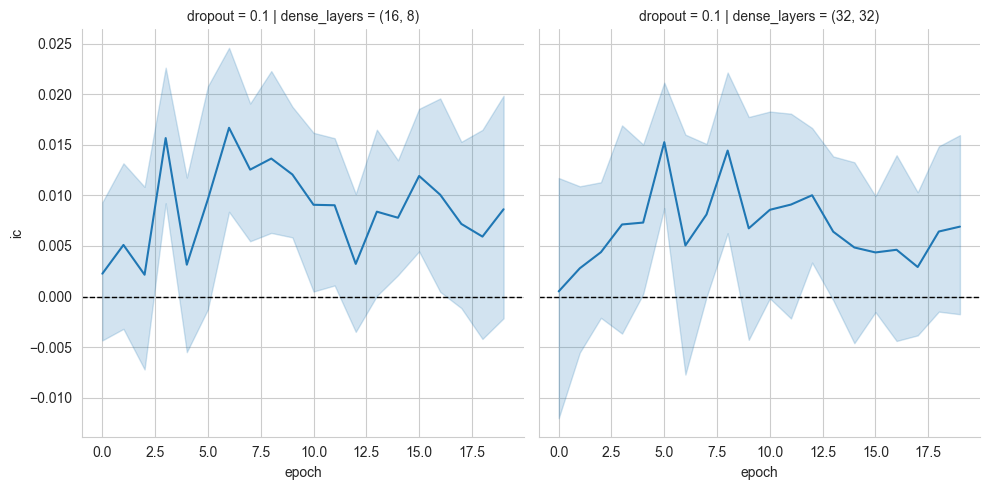

In [41]:
g = sns.relplot(x='epoch', y='ic', col='dense_layers', row='dropout', 
                data=ic_long[ic_long.dropout>0], kind='line')
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig(results_path / 'ic_lineplot', dpi=300);

In [46]:
params

['dense_layers', 'dropout', 'batch_size']

In [44]:
def run_ols(ic):
    ic.dense_layers = ic.dense_layers.str.replace(', ', '-').str.replace('(', '').str.replace(')', '')
    data = pd.melt(ic, id_vars=params, var_name='epoch', value_name='ic')
    data.epoch = data.epoch.astype(int).astype(str).apply(lambda x: f'{int(x):02.0f}')
    model_data = pd.get_dummies(data.sort_values(params + ['epoch']), columns=['epoch'] + params, drop_first=True).sort_index(1)
    model_data.columns = [s.split('_')[-1] for s in model_data.columns]
    model = sm.OLS(endog=model_data.ic, exog=sm.add_constant(model_data.drop('ic', axis=1)))
    return model.fit()

In [45]:
model = run_ols(ic.drop('fold', axis=1))

TypeError: DataFrame.sort_index() takes 1 positional argument but 2 were given

In [47]:
print(model.summary())

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 32)                1024      
                                                                 
 activation_46 (Activation)  (None, 32)                0         
                                                                 
 dense_70 (Dense)            (None, 32)                1056      
                                                                 
 activation_47 (Activation)  (None, 32)                0         
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                                 
 dense_71 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2113 (8.25 KB)
Trainable params: 2113 (

AttributeError: 'Sequential' object has no attribute 'conf_int'

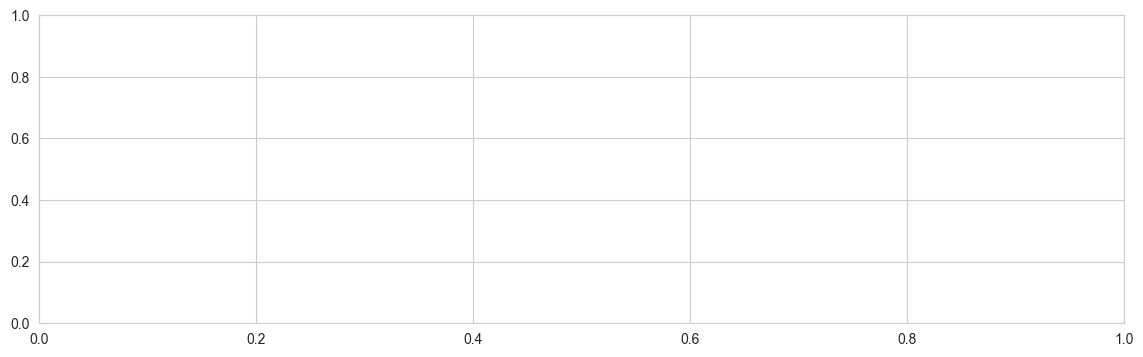

In [48]:
fig, ax = plt.subplots(figsize=(14, 4))

ci = model.conf_int()
errors = ci[1].sub(ci[0]).div(2)

coefs = (model.params.to_frame('coef').assign(error=errors)
         .reset_index().rename(columns={'index': 'variable'}))
coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]

coefs.plot(x='variable', y='coef', kind='bar',
           ax=ax, color='none', capsize=3,
           yerr='error', legend=False, rot=0, title='Impact of Architecture and Training Parameters on Out-of-Sample Performance')
ax.set_ylabel('IC')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

ax.annotate('Batch Size', xy=(.02, -0.1), xytext=(.02, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=1.3, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Layers', xy=(.1, -0.1), xytext=(.1, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=4.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Dropout', xy=(.2, -0.1), xytext=(.2, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=2.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Epochs', xy=(.62, -0.1), xytext=(.62, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=30.5, lengthB=1.0', lw=1.0, color='black'))

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'ols_coef', dpi=300)

## Make Predictions

In [49]:
def get_best_params(n=5):
    """Get the best parameters across all folds by daily median IC"""
    params = ['dense_layers', 'activation', 'dropout', 'batch_size']
    ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('fold', axis=1)
    dates = sorted(ic.index.unique())
    train_period = 24 * 21
    train_dates = dates[:train_period]
    ic = ic.loc[train_dates]
    return (ic.groupby(params)
            .median()
            .stack()
            .to_frame('ic')
            .reset_index()
            .rename(columns={'level_4': 'epoch'})
            .nlargest(n=n, columns='ic')
            .drop('ic', axis=1)
            .to_dict('records'))

In [50]:
def generate_predictions(dense_layers, activation, dropout, batch_size, epoch):
    data = pd.read_hdf('../12_gradient_boosting_machines/data.h5', 'model_data').dropna().sort_index()
    outcomes = data.filter(like='fwd').columns.tolist()
    X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
    input_dim = X_cv.shape[1]
    y_cv = data.loc[idx[:, :'2017'], 'r01_fwd']

    scaler = StandardScaler()
    predictions = []
    
    do = '0' if str(dropout) == '0.0' else str(dropout)
    checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(do) / str(batch_size)
        
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
        x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
        x_val = scaler.fit(x_train).transform(x_val)
        model = make_model(make_tuple(dense_layers), activation, dropout)
        status = model.load_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(x_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [51]:
best_params = get_best_params()
predictions = []
for i, params in enumerate(best_params):
    predictions.append(generate_predictions(**params).to_frame(i))

predictions = pd.concat(predictions, axis=1)
print(predictions.info())
predictions.to_hdf(results_path / 'test_preds.h5', 'predictions')

1959/1959 [==============================] - 3s 2ms/step
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 748960 entries, ('A', Timestamp('2017-08-30 00:00:00')) to ('ZION', Timestamp('2015-03-02 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       748960 non-null  float32
 1   1       748960 non-null  float32
 2   2       748960 non-null  float32
 3   3       748960 non-null  float32
 4   4       748960 non-null  float32
dtypes: float32(5)
memory usage: 17.2+ MB
None


In [52]:
predictions

0         1         2         3         4
symbol date                                                        
A      2017-08-30 -0.000929  0.000647  0.001133  0.001204 -0.000418
       2017-08-31 -0.001654  0.000038  0.000660  0.000604 -0.001166
       2017-09-01 -0.001446  0.000099  0.000997  0.001006 -0.000594
       2017-09-05 -0.001741  0.000600  0.000250  0.001151 -0.000829
       2017-09-06 -0.001700  0.000422  0.000394  0.000100 -0.001192
...                     ...       ...       ...       ...       ...
ZION   2015-02-24  0.002912  0.000711  0.007213  0.002241  0.002402
       2015-02-25  0.002242  0.000514  0.006568  0.002014  0.000857
       2015-02-26  0.002837  0.002275  0.005544  0.000162  0.001516
       2015-02-27  0.002191  0.003108  0.004298  0.000448  0.001023
       2015-03-02  0.000353  0.002471  0.003519  0.001272 -0.000635

[748960 rows x 5 columns]

### How to further improve the results

The relatively simple architecture yields some promising results. To further improve performance, you can
- First and foremost, add new features and more data to the model
- Expand the set of architectures to explore, including more or wider layers
- Inspect the training progress and train for more epochs if the validation error continued to improve at 50 epochs

Finally, you can use more sophisticated architectures, including Recurrent Neural Networks (RNN) and Convolutional Neural Networks that are well suited to sequential data, whereas vanilla feedforward NNs are not designed to capture the ordered nature of the features.
